<a href="https://colab.research.google.com/github/davidib19/PrecipitationForecasting/blob/master/RainOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
import keras
from keras import layers
import os
import pickle
import numpy as np
import xarray
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
strategy = tf.distribute.MirroredStrategy()

HEIGHT = 9
WIDTH = 9
INPUT_SHAPE = (None, 1, 72)
OUTPUT_SHAPE = (None, 24)

In [35]:
X_train=np.load('/content/X_train.npy')
y_train=np.load('/content/y_train.npy')


In [28]:
print(X_train.shape)

(3366, 72, 9, 9, 7)


In [36]:
X_train=X_train[:,:,3,3,3]

In [37]:
X_train*=1000
y_train*=1000

In [38]:
X_train = X_train[:, np.newaxis, :]

In [32]:
print(X_train.shape)

(3366, 1, 72)


In [33]:

def find_means_and(data):
    """Normaliza los datos para que tengan media 0 y desviación estándar 1"""
    means=np.zeros((9,9,7))
    stds=np.zeros((9,9,7))
    N=data[:,0,0,0].size
    for v in range(7):
      for i in range(9):
        for j in range(9):
            means[i,j,v]=np.sum(data[:,i,j,v])/N
            stds[i,j,v]=np.std(data[:,i,j,v])

    return means, stds

def normalize(means,stds, Xdata):
    for k in [0,2,4,5,6]:
      for i in range(9):
        for j in range(9):
            Xdata[:, i, j, k] = (Xdata[ :, i, j, k] - means[i,j,k]) / stds[i,j,k]
    for i in range(9):
        for j in range(9):
            Xdata[:, i, j, 1] = (Xdata[ :, i, j, 1] / means[i,j,1])
    Xdata[:,i,j,3]*=1000


    return Xdata
means, stds= find_means_and(X_train)
X_train=normalize(means,stds,X_train)
y_train*=1000


IndexError: ignored

In [ ]:
from collections import namedtuple

class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding,name=None,**kwargs):
        """
        A sequence of convolutional layers that first apply the convolution operation over the
        spatial dimensions, and then the temporal dimension.
        """
        super(Conv2Plus1D, self).__init__(name=name)
        self.filters=filters
        self.kernel_size=kernel_size
        self.padding=padding
        super(Conv2Plus1D, self).__init__(**kwargs)

        self.seq = keras.Sequential([
            # Spatial decomposition
            layers.Conv3D(filters=filters,
                          kernel_size=(1, kernel_size[1], kernel_size[2]),
                          padding=padding),
            # Temporal decomposition
            layers.Conv3D(filters=filters,
                          kernel_size=(kernel_size[0], 1, 1),
                          padding=padding)
        ])

    def call(self, x):
        return self.seq(x)


In [39]:
from keras.src.layers import concatenate
with strategy.scope():
  input = tf.keras.Input(shape=INPUT_SHAPE[1:])

  x = input
  x = tf.keras.layers.Conv1D(filters=32, kernel_size=(8), padding='valid',data_format="channels_first")(x)
  x = tf.keras.activations.sigmoid(x)
  x = tf.keras.layers.Conv1D(filters=18, kernel_size=(24), padding='valid',data_format="channels_first")(x)
  #x = layers.AveragePooling3D((1,2,2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(24)(x)
  x = tf.keras.activations.relu(x)
  x = keras.Model(inputs=input, outputs=x)


  model = keras.Model(inputs=x.input, outputs=x.output)
  #model.build(frames)
  model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
               metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(x=X_train,
                    epochs=70,
                    y=y_train, validation_split=0.2,batch_size=32)
tf.keras.models.save_model(model, '/content/OnlyWeather.keras')


Epoch 1/70
85/85 [==============================] - 2s 10ms/step - loss: 0.3055 - root_mean_squared_error: 0.5527 - val_loss: 0.2921 - val_root_mean_squared_error: 0.5404
Epoch 2/70
85/85 [==============================] - 1s 10ms/step - loss: 0.2652 - root_mean_squared_error: 0.5149 - val_loss: 0.2894 - val_root_mean_squared_error: 0.5379
Epoch 3/70
85/85 [==============================] - 1s 10ms/step - loss: 0.2614 - root_mean_squared_error: 0.5113 - val_loss: 0.2848 - val_root_mean_squared_error: 0.5337
Epoch 4/70
85/85 [==============================] - 1s 11ms/step - loss: 0.2580 - root_mean_squared_error: 0.5080 - val_loss: 0.2828 - val_root_mean_squared_error: 0.5318
Epoch 5/70
85/85 [==============================] - 1s 10ms/step - loss: 0.2569 - root_mean_squared_error: 0.5069 - val_loss: 0.2873 - val_root_mean_squared_error: 0.5360
Epoch 6/70
85/85 [==============================] - 1s 9ms/step - loss: 0.2543 - root_mean_squared_error: 0.5043 - val_loss: 0.2800 - val_root_me

In [40]:
X_test=np.load('/content/X_test.npy')
y_test=np.load('/content/y_test.npy')
X_test=X_test[:,:,3,3,3]*1000
X_test=X_test[:, np.newaxis, :]
y_test=y_test*1000


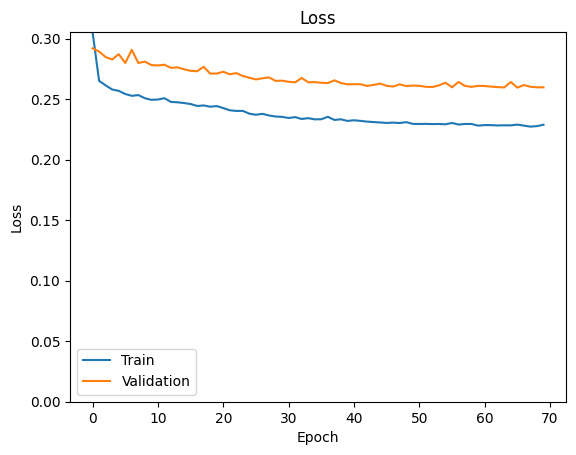

In [41]:
def plot_history(history):
    """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """

    # Plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Loss')


    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    plt.ylim([0, max_loss])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot accuracy
    #ax2.set_title('Root')
    #ax2.plot(history.history['accuracy'], label='train')
    #ax2.plot(history.history['val_accuracy'], label='test')
    #ax2.set_ylabel('Accuracy')
    #ax2.set_ylim([0, max(history.history['accuracy']+history.history['val_accuracy'])])
    #ax2.set_xlabel('Epoch')
    #ax2.legend(['Train', 'Validation'])

    plt.show()


plot_history(history)


In [42]:
y_predicted=model.predict(X_test)

23/23 [==============================] - 0s 4ms/step


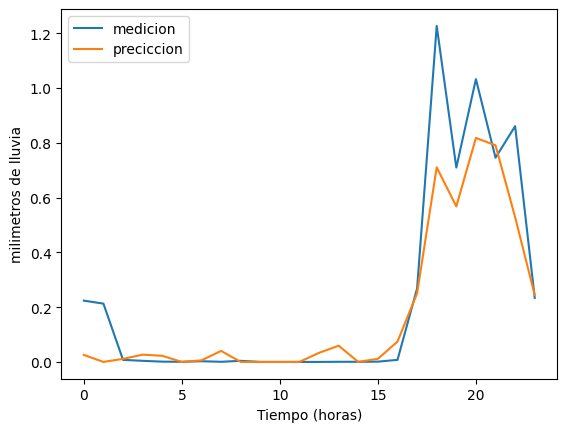

In [48]:
plt.xlabel('Tiempo (horas)')
plt.ylabel('milimetros de lluvia')
plt.plot(y_test[120],label='medicion')
plt.plot(y_predicted[120],label='preciccion')
plt.legend()
plt.show()

In [46]:
import math
MSE = np.square(np.subtract(y_test,y_predicted)).mean()

RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.5023972739364383
